In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2
import glob

import sys
sys.path.append("../../") # include parent dir

from jlonevae_lib.architecture.load_model import load_model
import jlonevae_lib.architecture.vae_jacobian as vj

In [4]:
# see dataset formatting instructions
# at https://github.com/rr-learning/disentanglement_dataset
rawdata = np.load("../../data/mpi3d_real/mpi3d_real.npz")['images']

In [5]:
rawdata.shape

(1036800, 64, 64, 3)

In [6]:
#inds has four rows, each row has a list of data indices for images to use
# shape is 4 by num, and the values are all between 0 and 1036800-1
def get_multi_data(allinds):
    inner_imgs = []
    for quartinds in allinds:
        inner_imgs.append(rawdata[quartinds][:,0:64:2,0:64:2,:] / 255.)
    # combine all 4 sampled images into one image
    # index 0 of inner_imgs is image sample number
    #print(inner_imgs[0].shape)
    return np.concatenate((
                 np.concatenate((inner_imgs[0],inner_imgs[1]),axis=1),
                 np.concatenate((inner_imgs[2],inner_imgs[3]),axis=1)), axis=2).transpose(0,3,1,2)

In [7]:
def get_data():
    factor_sizes = [6, 6, 2, 3, 3, 40, 40]
    factor_bases = np.prod(factor_sizes) / np.cumprod(
            factor_sizes)
    all_factors = np.random.randint(40,size=(4,7))
    all_factors[:,0] = 3
    all_factors[:,1] = 1
    all_factors[:,2] = 1 
    all_factors[:,3] = 0 
    all_factors[:,4] = 2 
    allinds = np.array(np.dot(all_factors, factor_bases), dtype=np.int64).reshape([4,1])
    imgs = get_multi_data(allinds)
    return imgs

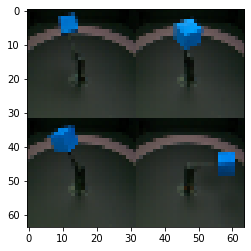

In [8]:
plt.imshow(get_data()[0].transpose(1,2,0))

# Embed into model

In [9]:
combinedOutputs = "trainedModels"

In [10]:
device="cuda"
def get_model_and_enc(gammastring, data, timestamp="*"):
    base_locs = np.array([[32/64., 16/64.],[48/64,32/64.],[16/64.,48/64.]])
    matching_model_paths = glob.glob(f"../{combinedOutputs}/defaultConv_lone_beta0_0100_ica{gammastring}_lat10_batch64_lr0_0001_anneal100000/{timestamp}/representation/cache_batch_no300000")
    model_path = matching_model_paths[0]

    model = load_model(model_path,device).double();
    encoding, logvar = model.encode(torch.tensor(data).double().to(device));
    return model, encoding

# Find the most active columns and plot them 

In [11]:
outputdir = "./mpi3dMultiJacobians/"
from pathlib import Path
Path.mkdir(Path(outputdir), exist_ok=True)

In [12]:
data = get_data()
for gammastring in ("0_0100", "0_0000"):
    model, encoding = get_model_and_enc(gammastring,data)
    rec = model.decode(torch.tensor(encoding).double().to(device))
    rec = rec.detach().cpu().numpy()[0].transpose(1,2,0)
    plt.imshow(data[0].transpose(1,2,0));plt.show();plt.close();
    # convert RGB to BGR and scale to 0-255
    cv2.imwrite(outputdir+"Mpi3dMulti-ExampleImage.png", (data[0].transpose(1,2,0)*255)[:,:,(2,1,0)]);
    plt.imshow(rec);plt.show();plt.close();
    cv2.imwrite(outputdir+f"Mpi3dMulti-ReconImageGamma{gammastring}.png", (rec*255)[:,:,(2,1,0)]);
    # contrast adjustment for jacobian
    scale = 5
    jacs = vj.compute_generator_jacobian_analytic(model, encoding, device=device,
                                        im_channels=3)#.detach().cpu().numpy()
    activities = [np.sum(np.square(jac)) for jac in jacs]
    top_jac_inds = np.flip(np.argsort(activities))
    gsc = np.std(np.abs(jacs))
    for q, ind in enumerate(top_jac_inds):
        print(jacs[ind].squeeze().shape)
        added_constrast_jac = jacs[ind,0].transpose(1,2,0) /gsc * 0.1
        added_constrast_jac = np.abs(added_constrast_jac)
        plt.imshow(added_constrast_jac);plt.show();plt.close();
        print(np.min(added_constrast_jac), np.max(added_constrast_jac))
        cv2.imwrite(outputdir+"Mpi3dMulti-JacGamma%sLatent%d.png" %(gammastring,q), 255*added_constrast_jac[:,:,(2,1,0)]);

IndexError: list index out of range